<a href="https://colab.research.google.com/github/fazaghifari/Notebook-Collections/blob/master/NLP_and_timeseries/Recipe_Generator_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recipe Generator with GPT-2
This model is far from perfect, further fine tuning or try using larger GPT-2 model is needed.

---
## Initialization

### Install transformers

In [1]:
!pip install transformers

---
### Check GPU

In [2]:
!nvidia-smi

Sat Jun 13 02:01:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
## Prepare Dataset

---
### Load data from GDrive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import pandas as pd
import pickle
raw_recipes_file = 'RAW_recipes.csv'
map_file = 'ingr_map.pkl'
folder = '/content/drive/My Drive/datasets/food_recipe/'
raw_recipes_path = os.path.join(folder,raw_recipes_file)
map_path = os.path.join(folder,map_file)
raw_recipes_df = pd.read_csv(raw_recipes_path, delimiter=',',
                            converters={'tags': eval, 'nutrition': eval, 'steps': eval, 'ingredients': eval})
infile = open(map_path,'rb')
ingr_map = pickle.load(infile, encoding='bytes')
raw_recipes_df = raw_recipes_df.dropna()

In [5]:
raw_recipes_df.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"[preheat oven to 425 degrees f, press dough in...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"[time-to-make, course, preparation, main-dish,...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"[brown ground beef in large pot, add chopped o...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13


In [6]:
raw_recipes_df['ingredients'].iloc[0]

['winter squash',
 'mexican seasoning',
 'mixed spice',
 'honey',
 'butter',
 'olive oil',
 'salt']

---
### Let's Create a plain recipe text

In [0]:
def convert_to_plain_text(name, ingredients, steps):
    text = '\n'+name+' \ningredients: \n'
    for ii, ingredient in enumerate(ingredients):
        text += str(ii+1)+'. '+ingredient+'. \n'
    text = text[:-3] + '. \nsteps: \n'
    for ii, step in enumerate(steps):
        text += str(ii+1)+'. '+step+'. \n'
    text += str(ii+2)+'. Finished \n\n'
    return text
    

In [8]:
name = raw_recipes_df['name'].iloc[0]
ingredients = raw_recipes_df['ingredients'].iloc[0]
steps = raw_recipes_df['steps'].iloc[0]
recipe = convert_to_plain_text(name, ingredients, steps)
print(recipe)


arriba   baked winter squash mexican style 
ingredients: 
1. winter squash. 
2. mexican seasoning. 
3. mixed spice. 
4. honey. 
5. butter. 
6. olive oil. 
7. salt. 
steps: 
1. make a choice and proceed with recipe. 
2. depending on size of squash , cut into half or fourths. 
3. remove seeds. 
4. for spicy squash , drizzle olive oil or melted butter over each cut squash piece. 
5. season with mexican seasoning mix ii. 
6. for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece. 
7. season with sweet mexican spice mix. 
8. bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin. 
9. be careful not to burn the squash especially if you opt to use sugar or butter. 
10. if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking. 
11. if desired , season with salt. 
12. Finished 




In [9]:
import numpy as np
import random

recipes = []
for idx, row in raw_recipes_df.iterrows():
    name = row['name']
    if type(name) is not str:
        print(name)
        break
    ingredients = row['ingredients']
    steps = row['steps']
    recipes.append(convert_to_plain_text(name, ingredients, steps))
for ii in range(2):
    print(recipes[ii])

recipe_length = np.array([len(recipe) for recipe in recipes])
idx_less_than = np.where(recipe_length <= 2000)[0]
print(len(idx_less_than))
idx_less_than = random.sample(idx_less_than.tolist(), 100000)
print(idx_less_than[:20])


arriba   baked winter squash mexican style 
ingredients: 
1. winter squash. 
2. mexican seasoning. 
3. mixed spice. 
4. honey. 
5. butter. 
6. olive oil. 
7. salt. 
steps: 
1. make a choice and proceed with recipe. 
2. depending on size of squash , cut into half or fourths. 
3. remove seeds. 
4. for spicy squash , drizzle olive oil or melted butter over each cut squash piece. 
5. season with mexican seasoning mix ii. 
6. for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece. 
7. season with sweet mexican spice mix. 
8. bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin. 
9. be careful not to burn the squash especially if you opt to use sugar or butter. 
10. if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking. 
11. if desired , season with salt. 
12. Finished 



a bit different  breakfast pizza 
ingredients: 
1. pre

In [0]:
long_recipes = ''.join([recipes[i] for i in idx_less_than])
file1 = open("MyFile2000.txt","w")
file1.write(long_recipes)
file1.close()

---
## Fine Tuning Pretrained GPT-2

----
### Load Plain text file

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    print(f'Device name = {torch.cuda.get_device_name(0)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...
Device name = Tesla P100-PCIE-16GB


In [0]:
text_file = open("MyFile2000.txt", "r")
recipes = text_file.read().split('\n\n')

In [13]:
recipe_length = [len(recipe) for recipe in recipes]
recipe_length[:10]

[757, 816, 1486, 832, 1296, 696, 222, 351, 590, 437]

0
1998
773.6066239337607
709


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


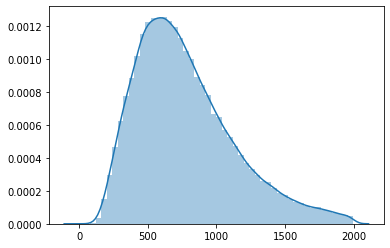

In [14]:
# Character length of each recipe
import statistics
import seaborn as sns
print(min(recipe_length))
print(max(recipe_length)) 
print(statistics.mean(recipe_length)) 
print(statistics.median(recipe_length))
sns.distplot(recipe_length)

---
### Create Dataset Loader

In [0]:
max_length = 768
pretrained_model = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model)
tokenizer.pad_token = tokenizer.eos_token
recipes_str = '\n\n'.join(recipes)
class RecipeDataset(Dataset):
    def __init__(self, recipes, tokenizer, max_len):
        self.sentences = recipes
        self.tokenizer = tokenizer
        self.max_len = max_len

        block_size = self.max_len - (
            self.tokenizer.max_len - self.tokenizer.max_len_single_sentence
        )

        tokenized_text = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(self.sentences))
        self.examples = []
        for i in range(0, len(tokenized_text) - block_size + 1, block_size):
                self.examples.append(
                    tokenizer.build_inputs_with_special_tokens(
                        tokenized_text[i : i + block_size]
                    )
                )
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

        return {
        'text': sentence,
        'input_ids': encoded['input_ids'].flatten(),
        'attention_mask': encoded['attention_mask'].flatten()
        }

def create_loader(recipes, tokenizer, max_len, batch_size):
  ds = RecipeDataset(
    recipes=recipes,
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

train_batch_size = 4

train_loader = create_loader(recipes_str, tokenizer, max_length, train_batch_size)

In [16]:
dataiter = iter(train_loader)
data = next(dataiter)

print('Sample input size: ', data.shape)
print('Sample input: ', data)
print('Sample 1: \n', tokenizer.decode(data[0], skip_special_tokens=True))

Sample input size:  torch.Size([4, 768])
Sample input:  tensor([[  198,  1350,   891,  ...,   285,  1586,   518],
        [  416,   262,   352,  ...,   351,   517,   374],
        [ 5185,    78,  9891,  ...,   290, 11348, 18128],
        [ 8163, 26320, 28450,  ...,  1566,   262, 15756]])
Sample 1: 
 
beef short ribs stew 
ingredients: 
1. short rib of beef. 
2. olive oil. 
3. onion. 
4. carrots. 
5. celery. 
6. garlic. 
7. red wine. 
8. tomato paste. 
9. beef stock. 
10. bay leaves. 
11. fresh thyme. 
12. salt and pepper. 
steps: 
1. heat oil in a large pot, season ribs and brown evenly and thoroughly. 
2. remove ribs and reserve on a plate, and then add onions, carrot and celery to the pot. 
3. saut, making sure to scrape up any brown bits on the bottom of the pan until the vegetables are caramelized. 
4. add garlic, wine and tomato paste and stir well. 
5. add beef stock and beef and bring to a simmer, covered, for 2-3 hours, until meat is very tender, and beginning to fall of the bo

---
### Define Model

In [0]:
model = GPT2LMHeadModel.from_pretrained(pretrained_model)

In [0]:
BATCH_SIZE = 1
EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_STEPS = 10000

In [0]:
torch.cuda.empty_cache()
model = model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=-1)
sum_loss = 0.0
batch_count = 0

---
### Train Model

In [20]:
print(recipes_str[:1000])


beef short ribs stew 
ingredients: 
1. short rib of beef. 
2. olive oil. 
3. onion. 
4. carrots. 
5. celery. 
6. garlic. 
7. red wine. 
8. tomato paste. 
9. beef stock. 
10. bay leaves. 
11. fresh thyme. 
12. salt and pepper. 
steps: 
1. heat oil in a large pot , season ribs and brown evenly and thoroughly. 
2. remove ribs and reserve on a plate , and then add onions , carrot and celery to the pot. 
3. saut , making sure to scrape up any brown bits on the bottom of the pan until the vegetables are caramelized. 
4. add garlic , wine and tomato paste and stir well. 
5. add beef stock and beef and bring to a simmer , covered , for 2-3 hours , until meat is very tender , and beginning to fall of the bone. 
6. serve with mashed potatoes. 
7. Finished 


maharaja curry 
ingredients: 
1. vegetable oil. 
2. cumin seed. 
3. onions. 
4. ground turmeric. 
5. cayenne pepper. 
6. garam masala. 
7. garlic clove. 
8. ginger. 
9. chopped tomatoes. 
10. boneless chicken breast. 
steps: 
1. heat oil in

In [23]:
import time
from tqdm.notebook import tqdm
print("Training on ", device)
print("====================TRAINING PROCESS====================")
for epoch in range(EPOCHS):
    print(f"EPOCH {epoch} started" + '=' * 30)
    time.sleep(0.2)
    t0 = time.time()
    # keep track of training and validation loss
    train_loss = 0.0
    script_count = 0

    for d in tqdm(train_loader):
        input_ids = d.to(device)
        labels = d.to(device)
        outputs = model(input_ids, labels=labels)
        script_count = script_count + 1
        loss, logits = outputs[:2]                        
        loss.backward()
        train_loss = train_loss + loss.detach().data
                       
        optimizer.step()
        # scheduler.step() 
        optimizer.zero_grad()
        model.zero_grad()

        if script_count % 250 == 0:
            print("Epoch: {}/{}...".format(epoch+1, EPOCHS),
            "Step: {}...".format(script_count),
            "Loss: {:.6f}...".format(train_loss/script_count),
           "Time elapsed: {:.1f}".format( time.time()-t0))

Training on  cuda:0
====================TRAINING PROCESS====================
EPOCH 0 started==============================


Epoch: 1/2... Step: 250... Loss: 1.634520... Time elapsed: 134.4
Epoch: 1/2... Step: 500... Loss: 1.613649... Time elapsed: 268.4
Epoch: 1/2... Step: 750... Loss: 1.594459... Time elapsed: 402.5
Epoch: 1/2... Step: 1000... Loss: 1.577263... Time elapsed: 536.8
Epoch: 1/2... Step: 1250... Loss: 1.562351... Time elapsed: 671.1
Epoch: 1/2... Step: 1500... Loss: 1.550785... Time elapsed: 805.4
Epoch: 1/2... Step: 1750... Loss: 1.539942... Time elapsed: 939.7
Epoch: 1/2... Step: 2000... Loss: 1.530887... Time elapsed: 1074.2
Epoch: 1/2... Step: 2250... Loss: 1.521158... Time elapsed: 1208.5
Epoch: 1/2... Step: 2500... Loss: 1.512070... Time elapsed: 1342.9
Epoch: 1/2... Step: 2750... Loss: 1.504713... Time elapsed: 1477.3
Epoch: 1/2... Step: 3000... Loss: 1.498210... Time elapsed: 1611.8
Epoch: 1/2... Step: 3250... Loss: 1.490958... Time elapsed: 1746.2
Epoch: 1/2... Step: 3500... Loss: 1.485000... Time elapsed: 1880.6
Epoch: 1/2... Step: 3750... Loss: 1.478581... Time elapsed: 2015.2
Epoch

Epoch: 2/2... Step: 250... Loss: 1.305289... Time elapsed: 134.6
Epoch: 2/2... Step: 500... Loss: 1.300605... Time elapsed: 269.1
Epoch: 2/2... Step: 750... Loss: 1.298922... Time elapsed: 403.5
Epoch: 2/2... Step: 1000... Loss: 1.296748... Time elapsed: 537.9
Epoch: 2/2... Step: 1250... Loss: 1.294306... Time elapsed: 672.3
Epoch: 2/2... Step: 1500... Loss: 1.293636... Time elapsed: 806.8
Epoch: 2/2... Step: 1750... Loss: 1.292798... Time elapsed: 941.2
Epoch: 2/2... Step: 2000... Loss: 1.292143... Time elapsed: 1075.7
Epoch: 2/2... Step: 2250... Loss: 1.290253... Time elapsed: 1210.1
Epoch: 2/2... Step: 2500... Loss: 1.288178... Time elapsed: 1344.6
Epoch: 2/2... Step: 2750... Loss: 1.287331... Time elapsed: 1479.0
Epoch: 2/2... Step: 3000... Loss: 1.286575... Time elapsed: 1613.3
Epoch: 2/2... Step: 3250... Loss: 1.284700... Time elapsed: 1747.7
Epoch: 2/2... Step: 3500... Loss: 1.283678... Time elapsed: 1882.2
Epoch: 2/2... Step: 3750... Loss: 1.281945... Time elapsed: 2016.6
Epoch

In [24]:
from transformers import WEIGHTS_NAME, CONFIG_NAME
print(WEIGHTS_NAME,' ',CONFIG_NAME)
torch.save(model.state_dict(), '/content/drive/My Drive/datasets/food_recipe/recipe_model2.pt')
model.config.to_json_file('/content/drive/My Drive/datasets/food_recipe/config2.json')
tokenizer.save_vocabulary('/content/drive/My Drive/datasets/food_recipe/')

pytorch_model.bin   config.json


('/content/drive/My Drive/datasets/food_recipe/vocab.json',
 '/content/drive/My Drive/datasets/food_recipe/merges.txt')

---
## Evaluate Model

In [0]:
input_ids = tokenizer.encode('spicy chicken rice', return_tensors='pt')

In [42]:
model.eval()
sample_outputs = model.generate(
                        input_ids= input_ids.to(device),
                        do_sample=True,
                        num_beams= 5,
                        max_length = 350,
                        temperature = 0.7,
                        top_p=0.85,
                        repetition_penalty = 1,
                    )

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
      print("{}".format(tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Output:
----------------------------------------------------------------------------------------------------
spicy chicken rice 
ingredients: 
1. chicken breasts. 
2. onion. 
3. garlic cloves. 
4. ground cumin. 
5. ground coriander. 
6. ground turmeric. 
7. ground cayenne pepper. 
8. salt. 
9. black pepper. 
10. vegetable oil. 
11. rice. 
12. water. 
13. cilantro. 
steps: 
1. heat the oil in a large skillet over medium heat. 
2. add the chicken, onion, garlic, cumin, coriander, turmeric, cayenne pepper, salt and pepper. 
3. saute until the chicken is no longer pink, about 5 minutes. 
4. add the rice and water. 
5. bring to a boil. 
6. reduce the heat and simmer, covered, until the rice is tender, about 20 minutes. 
7. stir in the cilantro. 
8. serve hot. 
9. Finished 


sausage and cheese casserole 
ingredients: 
1. bulk pork sausage. 
2. onion. 
3. cream of mushroom soup. 
4. milk. 
5. cheddar cheese. 
6. cheddar cheese. 
7. salt. 
8. pepper. 
9. cayenne pepper. 
steps: 
1. brown saus